In [104]:
using VeryDiff
using LinearAlgebra
using Plots
using DataStructures
using Gurobi, JuMP

include("util.jl")

VeryDiff.NEW_HEURISTIC = true

true

In [105]:
function is_epsilon_counterexample(ϵ)
    return (N₁, N₂, cex) -> begin
        return VeryDiff.get_sample_distance(N₁, N₂, cex) > ϵ
    end
end

is_epsilon_counterexample (generic function with 1 method)

In [106]:
function to_dict_key(node :: SplitNode)
    (;network, layer, neuron) = node
    return "$network,$layer,$neuron"
end

to_dict_key (generic function with 1 method)

In [107]:
function plot_diff_zono(∂Z; title="Output")
    plot(∂Z.Z₁, label="Z₁", framestyle=:origin, alpha=0.5, title=title)
    plot(∂Z.Z₂, label="Z₂", alpha=0.5)
    plot!(∂Z.∂Z, label="∂Z", alpha=0.5)
end

plot_diff_zono (generic function with 1 method)

In [108]:
ϵ = 1.0e-3
property_check = get_epsilon_property(ϵ)
is_counterexample = is_epsilon_counterexample(ϵ)

#30 (generic function with 1 method)

In [109]:
function split_neuron(node :: SplitNode, prev_split :: Vector{SplitNode})
    split₁ = prev_split
    split₂ = deepcopy(prev_split)

    push!(split₁, SplitNode(node.network, node.layer, node.neuron, -1))
    push!(split₂, SplitNode(node.network, node.layer, node.neuron, 1))

    return split₁, split₂
end

split_neuron (generic function with 1 method)

In [110]:
function propagate(∂Zin, prop_state, split_nodes)
    split_candidates = SplitCandidate[]
    ∂Zout = N(∂Zin, prop_state; split_nodes=split_nodes, split_candidates=split_candidates)
    return ∂Zout, split_candidates
end

propagate (generic function with 1 method)

In [111]:
function search(N₁, N₂, ∂Zin, ∂Zout, prop_state, branch_splits)
    prop_satisfied, cex, _, _, _ = property_check(N₁, N₂, ∂Zin, ∂Zout, nothing)
    
    if !prop_satisfied
        if !isnothing(cex)
            return UNSAFE, cex
        end
        # Initialize the LP solver
        model = Model(() -> Gurobi.Optimizer(VeryDiff.GRB_ENV[]))
        set_time_limit_sec(model, 10)
        
        # Add variables and input and output constraints
        var_num = size(∂Zout.∂Z.G, 2)
        @variable(model, -1.0 <= x[1:var_num] <= 1.0)
        
        @constraint(model, copy(∂Zout.∂Z.G) * x + copy(∂Zout.∂Z.c) .>= ϵ + eps(ϵ))
        
        # Add split constraints
        for split_node in branch_splits
            (;g, c) = prop_state.split_generators[to_dict_key(split_node)]
            append!(g, zeros(var_num - size(g, 1)))
            @constraint(model, split_node.direction * (g' * x + c) >= 0.0)
        end

        @objective(model, Max, 0)
        optimize!(model)

        if is_solved_and_feasible(model)
            cex = value.(x)[1:size(∂Zin.Z₁.G, 2)]
            if is_counterexample(N₁, N₂, cex)
                return VeryDiff.UNSAFE, cex
            end
        end

        if termination_status(model) != MOI.INFEASIBLE
            return VeryDiff.UNKNOWN
        end
    end

    return VeryDiff.SAFE
end

search (generic function with 1 method)

In [112]:
function branch_and_bound(splits, branch_splits, split_candidates)
    split₁, split₂ = split_neuron(split_candidates[1].node, branch_splits)
    push!(splits, split₁, split₂)
end

branch_and_bound (generic function with 1 method)

In [113]:
layers1 = Layer[
    Dense([1.7901994999337738 -0.4375139492492878; -0.6463011149536566 -0.294362301893835], [0.4858268442695409, -0.3083995832971191]),
    ReLU(),
    Dense([1.347707452913051 -0.3146188184438083; -0.1724980704319044 1.3150142870758215], [-1.6489691121810657, 0.3154201062043038]),
    ReLU(),
    Dense([0.031313002692325044 0.9255109945797536; -0.6436521744948884 1.2500342629765357], [0.8820501333110521, -0.4141060871972209]),
    ReLU(),
    Dense([0.9686008564499987 -1.802808013449341; -0.18884926111600128 0.7735822224964346], [0.4599300554775193, -0.27958078103580214]),
    ReLU(),
    Dense([-0.37566416722901746 0.5662474712485283; -1.152400376401409 -0.12230326369286959], [0.05556857907521722, 0.0887560097096626]),
    ReLU(),
    Dense([0.4877370152355362 0.3992903477728307; -0.4916371434675079 -1.1227964794060794], [0.29456667601848685, 1.083292811708767]),
    ReLU(),
    Dense([0.08926318457803685 0.765030610066109; 0.9024287529989173 -0.7545201379880397], [-0.015334676676834219, 0.5675979257285917]),
    ReLU(),
    Dense([0.7673904813047289 -1.542237049832504; 0.010884097127559778 0.9322644923018855], [-1.3651666407584295, 0.023879238059846247]),
    ReLU(),
    Dense([0.3180228415729041 -0.07903625695921851; 0.9425850271902696 -0.7464757431612407], [-0.624130698523964, -0.2697997653000221]),
    ReLU(),
    Dense([0.17872459879005195 -0.179797304032193; -2.1836695250289 1.3454711687175822], [-0.12013260230442856, -1.0314024426119974]),
    ReLU(),
    Dense([-2.045191560947058 0.45139193468340244; -0.38928407556392314 -0.39667410409807896], [-0.6058976531933701, -0.7965043036498215]),
    ReLU()
]

layers2 = Layer[
    Dense([1.8001994999337738 -0.4375139492492878; -0.6463011149536566 -0.284362301893835], [0.49582684426954093, -0.2983995832971191]),
    ReLU(),
    Dense([1.357707452913051 -0.3146188184438083; -0.1724980704319044 1.3250142870758215], [-1.6389691121810657, 0.3254201062043038]),
    ReLU(),
    Dense([0.041313002692325046 0.9255109945797536; -0.6436521744948884 1.2600342629765358], [0.8920501333110521, -0.4041060871972209]),
    ReLU(),
    Dense([0.9786008564499987 -1.802808013449341; -0.18884926111600128 0.7835822224964346], [0.4699300554775193, -0.26958078103580213]),
    ReLU(),
    Dense([-0.36566416722901746 0.5662474712485283; -1.152400376401409 -0.1123032636928696], [0.06556857907521722, 0.0987560097096626]),
    ReLU(),
    Dense([0.4977370152355362 0.3992903477728307; -0.4916371434675079 -1.1127964794060794], [0.30456667601848686, 1.093292811708767]),
    ReLU(),
    Dense([0.09926318457803684 0.765030610066109; 0.9024287529989173 -0.7445201379880397], [-0.005334676676834219, 0.5775979257285917]),
    ReLU(),
    Dense([0.7773904813047289 -1.542237049832504; 0.010884097127559778 0.9422644923018855], [-1.3551666407584295, 0.033879238059846245]),
    ReLU(),
    Dense([0.3280228415729041 -0.07903625695921851; 0.9425850271902696 -0.7364757431612406], [-0.614130698523964, -0.2597997653000221]),
    ReLU(),
    Dense([0.18872459879005196 -0.179797304032193; -2.1836695250289 1.3554711687175822], [-0.11013260230442856, -1.0214024426119974]),
    ReLU(),
    Dense([-2.0351915609470583 0.45139193468340244; -0.38928407556392314 -0.38667410409807895], [-0.5958976531933701, -0.7865043036498215]),
    ReLU()
]
input_range = 9.0

9.0

In [114]:
layers1 = [
    Dense([0.33535358961162437 0.5256152763594955; -0.14027988648835477 -0.495682430249445], [-1.4219413584821645, -0.4746517089494962]),
    ReLU(),
    Dense([0.6822873060784103 -1.2136808125081082; 1.7137418733953302 -1.325011799325864], [-0.958768573493128, 0.08092682460623819]),
    ReLU(),
    Dense([0.7129948749264905 -0.4343819413964641; -0.05674185412677563 -1.5103858887210122], [2.0320492081389436, -0.5027520961021893]),
    ReLU(),
    Dense([0.948549945654497 0.8195703790580775; 0.6171408909437109 -1.5744771023806494], [-0.9129824338526503, -2.2348654632555665]),
    ReLU(),
    Dense([-0.06740325309621437 0.35461755761485314; -0.201282219416569 -1.8592215087081407], [0.34417393296313786, 1.5085477044382078]),
    ReLU(),
    Dense([-1.8633783118930656 0.5001724370275519; -0.5313605756099161 0.7560460322325064], [-0.6854344038002539, 0.6498890433878076]),
    ReLU(),
    Dense([-0.1808273836090649 0.6996908280399275; 1.6100753677763773 -0.20258969070390906], [-1.6465659266852066, 1.22235324155227]),
    ReLU(),
    Dense([0.4274907089823277 -0.0703810710220322; -0.3618865575187646 2.146361509885769], [-1.5537337958816944, 0.29103724227853167]),
    ReLU(),
    Dense([-0.07363557470541528 -1.0604538794785485; 0.40828813360175104 -0.6225585993822761], [0.5573037521329216, -0.9361067811701999]),
    ReLU(),
    Dense([-0.7083686728570325 -1.1332962894934944; -2.7294954668967133 -0.16662604575361725], [-0.3094225417683883, 0.3763226647166076]),
    ReLU(),
    Dense([-1.1307177100387331 -0.5683920733553828; -0.6533244435939018 0.1922088541222782], [0.03207954417063035, -1.3111364942158543]),
    ReLU(),
    Dense([1.3595853666090274 0.5978500900337331; 0.06465123721218738 -0.12123074035126402], [0.9789481098868837, -0.3937002134010107]),
    ReLU(),
    Dense([-0.5790786276273867 1.2457572397180992; -0.2069507195870086 -1.767163224351663], [0.2625077325827641, 1.3424464351081724]),
    ReLU(),
    Dense([-1.5384501620855067 -0.48419576599000613; -0.006830589908279123 0.26313229440183467], [0.30915668535791263, 0.23132530044086916]),
    ReLU(),
    Dense([-1.69015103328246 -1.660311108419943; -0.30874482136518444 0.43974246196903827], [0.9623426765209336, 0.8380460195411534]),
    ReLU(),
    Dense([1.4130768400771347 0.2854939820938101; -0.4939434675375873 -0.26526939125553983], [0.03185355011583268, -0.07313691832773785]),
    ReLU(),
    Dense([-0.7341908975643681 -0.5188511251326249; 1.0620219887789917 1.2061412724671468], [0.806891804687922, 1.096708968569041]),
    ReLU(),
    Dense([-0.6280001934855104 -1.6406584453820217; -0.0497787827575354 -1.7580100070133848], [0.26390326955208804, 0.779149526116883]),
    ReLU()
]

layers2 = [
    Dense([0.3453535896116244 0.5256152763594955; -0.14027988648835477 -0.485682430249445], [-1.4119413584821645, -0.4646517089494962]),
    ReLU(),
    Dense([0.6922873060784103 -1.2136808125081082; 1.7137418733953302 -1.315011799325864], [-0.948768573493128, 0.09092682460623819]),
    ReLU(),
    Dense([0.7229948749264905 -0.4343819413964641; -0.05674185412677563 -1.5003858887210122], [2.0420492081389434, -0.4927520961021893]),
    ReLU(),
    Dense([0.958549945654497 0.8195703790580775; 0.6171408909437109 -1.5644771023806494], [-0.9029824338526503, -2.2248654632555667]),
    ReLU(),
    Dense([-0.057403253096214364 0.35461755761485314; -0.201282219416569 -1.8492215087081407], [0.35417393296313787, 1.5185477044382079]),
    ReLU(),
    Dense([-1.8533783118930656 0.5001724370275519; -0.5313605756099161 0.7660460322325064], [-0.6754344038002539, 0.6598890433878076]),
    ReLU(),
    Dense([-0.17082738360906488 0.6996908280399275; 1.6100753677763773 -0.19258969070390905], [-1.6365659266852066, 1.23235324155227]),
    ReLU(),
    Dense([0.4374907089823277 -0.0703810710220322; -0.3618865575187646 2.1563615098857687], [-1.5437337958816943, 0.3010372422785317]),
    ReLU(),
    Dense([-0.06363557470541528 -1.0604538794785485; 0.40828813360175104 -0.6125585993822761], [0.5673037521329216, -0.9261067811701998]),
    ReLU(),
    Dense([-0.6983686728570325 -1.1332962894934944; -2.7294954668967133 -0.15662604575361724], [-0.2994225417683883, 0.3863226647166076]),
    ReLU(),
    Dense([-1.120717710038733 -0.5683920733553828; -0.6533244435939018 0.2022088541222782], [0.042079544170630354, -1.3011364942158543]),
    ReLU(),
    Dense([1.3695853666090274 0.5978500900337331; 0.06465123721218738 -0.11123074035126403], [0.9889481098868838, -0.3837002134010107]),
    ReLU(),
    Dense([-0.5690786276273867 1.2457572397180992; -0.2069507195870086 -1.757163224351663], [0.2725077325827641, 1.3524464351081724]),
    ReLU(),
    Dense([-1.5284501620855067 -0.48419576599000613; -0.006830589908279123 0.2731322944018347], [0.31915668535791264, 0.24132530044086917]),
    ReLU(),
    Dense([-1.68015103328246 -1.660311108419943; -0.30874482136518444 0.4497424619690383], [0.9723426765209336, 0.8480460195411534]),
    ReLU(),
    Dense([1.4230768400771348 0.2854939820938101; -0.4939434675375873 -0.2552693912555398], [0.04185355011583268, -0.06313691832773785]),
    ReLU(),
    Dense([-0.724190897564368 -0.5188511251326249; 1.0620219887789917 1.2161412724671468], [0.816891804687922, 1.106708968569041]),
    ReLU(),
    Dense([-0.6180001934855104 -1.6406584453820217; -0.0497787827575354 -1.7480100070133848], [0.27390326955208805, 0.789149526116883]),
    ReLU()
]
input_range = 8.38

8.38

In [115]:
layers1 = [
    Dense([1.3792230734446627 0.18072496804155294; 1.2711459272478396 -0.6222869538436543], [-1.0976112930782012, 1.7509179468964144]),
    ReLU(),
    Dense([-1.617300012546349 -1.1457290973915149; 0.8869264713687858 0.26338624534644156], [3.1238017337202777, -0.0651814615821752]),
    ReLU(),
    Dense([0.6087438875268779 -0.15964247287171593; 1.0892442909356017 -1.8124186045606616], [0.5507334460752988, 1.7067684158911918]),
    ReLU(),
    Dense([-0.07159820079572422 1.8109528957682102; -0.6289415160409288 -0.3802607305461082], [-0.6410759032773328, -0.5459767405446848]),
    ReLU(),
    Dense([-1.746541323008347 -0.09206482764416486; 0.563705220995798 -1.1018553258597146], [0.5561029944953708, 0.6423718603469796]),
    ReLU(),
    Dense([1.8010473076368232 -0.8010201372837944; -1.652665285574487 0.8761220913205824], [-1.3949822486249586, -1.1796542212478704]),
    ReLU(),
    Dense([-0.8862250765901228 1.0513551108548176; 0.7030582743411415 1.3013841267574129], [-0.6638393010122516, -0.12061446128791475]),
    ReLU(),
    Dense([-0.7161468412749878 0.3631185986299728; -1.666710938588277 -0.7074113018810734], [1.2461832048996488, -0.6538184999308579]),
    ReLU(),
    Dense([-0.2230159105206092 -1.7688547897926998; 0.024303975223247204 -0.911824650860103], [1.0630476651777196, 0.979901909751408]),
    ReLU(),
    Dense([-0.20662421462375777 -0.16403175244082258; 1.1604420058622025 -0.8576548998009965], [-0.2647328335485605, 0.09609833395877819]),
    ReLU(),
    Dense([1.363713570827604 -0.5901385259520291; -0.45163614205405145 2.0196202360501996], [1.741774203807737, 0.9455121550593799]),
    ReLU(),
    Dense([0.42578183036800515 -1.849435552006813; -1.4846629867166352 -0.9519431418730938], [0.9954545239557848, -0.9468166606766768]),
    ReLU(),
    Dense([-0.45800479173791253 -0.469613756388144; -0.1086673460001287 -0.5950783226339761], [0.23962229884080774, 0.4418375843512645]),
    ReLU(),
    Dense([0.160587337887127 -0.6593946414693055; 0.39011612148738656 -1.12062905344251], [-1.49908005887843, 0.015767229189535784]),
    ReLU(),
    Dense([-0.10757316094134729 2.202456653327997; 0.46703077437235857 -0.60171666794126], [-0.041800781999059365, 0.7536148586996111]),
    ReLU(),
    Dense([1.3350552173940715 -2.2839380306565005; -0.6368741955811404 0.2703534213793312], [-0.9480347480643606, 0.5159257749653468]),
    ReLU(),
    Dense([-0.14953311780472778 0.2676708558842546; 1.6548701429608208 0.4634442239575621], [-0.8506145495907595, -0.4934342797804856]),
    ReLU(),
    Dense([-0.4525234812204171 -0.47567675313579405; -0.044259565966585306 0.8758454366459557], [-0.18242024403106213, 0.24048149074819522]),
    ReLU(),
    Dense([0.9559851699356834 -0.8588726238645568; -0.8016641950158518 -1.3119316409170558], [0.1814201592494204, -0.48757363789728697]),
    ReLU(),
    Dense([-0.0305695355361467 -1.0503015636894895; 1.1975417728298652 1.4760931313661707], [0.09196702062339994, 0.13049892278150757]),
    ReLU(),
    Dense([0.3052569616076217 -1.3026154592755737; 1.0008866619568695 1.611829296613601], [-0.14113713838787775, -0.8170177519948233]),
    ReLU(),
    Dense([1.1657546955513112 -0.6266951548226481; 0.5808882218161988 -0.019692739907082688], [0.38753818153745334, 0.20673298399139436]),
    ReLU(),
    Dense([0.6060535520179534 -0.7575089415424734; -0.16848494988797633 -0.4167545291132801], [-0.05307353160464454, -1.0101905114580658]),
    ReLU(),
    Dense([-1.5909447792228462 0.032143293470698525; -0.056127612077389734 0.7836649320741601], [-0.6475986402128797, 0.010394954187355898]),
    ReLU(),
    Dense([0.18698430928522128 1.4207235299275678; -0.3107316065800691 -0.08215176366473187], [-0.7918522287455747, 0.4827686196675138]),
    ReLU()
]

layers2 = [
    Dense([1.3792330734446627 0.18072496804155294; 1.2711459272478396 -0.6222769538436543], [-1.097601293078201, 1.7509279468964145]),
    ReLU(),
    Dense([-1.617290012546349 -1.1457290973915149; 0.8869264713687858 0.26339624534644157], [3.1238117337202778, -0.06517146158217521]),
    ReLU(),
    Dense([0.6087538875268779 -0.15964247287171593; 1.0892442909356017 -1.8124086045606616], [0.5507434460752988, 1.7067784158911918]),
    ReLU(),
    Dense([-0.07158820079572423 1.8109528957682102; -0.6289415160409288 -0.3802507305461082], [-0.6410659032773328, -0.5459667405446849]),
    ReLU(),
    Dense([-1.746531323008347 -0.09206482764416486; 0.563705220995798 -1.1018453258597145], [0.5561129944953708, 0.6423818603469795]),
    ReLU(),
    Dense([1.8010573076368233 -0.8010201372837944; -1.652665285574487 0.8761320913205823], [-1.3949722486249585, -1.1796442212478704]),
    ReLU(),
    Dense([-0.8862150765901229 1.0513551108548176; 0.7030582743411415 1.301394126757413], [-0.6638293010122517, -0.12060446128791476]),
    ReLU(),
    Dense([-0.7161368412749879 0.3631185986299728; -1.666710938588277 -0.7074013018810734], [1.246193204899649, -0.653808499930858]),
    ReLU(),
    Dense([-0.2230059105206092 -1.7688547897926998; 0.024303975223247204 -0.911814650860103], [1.0630576651777197, 0.979911909751408]),
    ReLU(),
    Dense([-0.20661421462375776 -0.16403175244082258; 1.1604420058622025 -0.8576448998009966], [-0.26472283354856047, 0.09610833395877819]),
    ReLU(),
    Dense([1.363723570827604 -0.5901385259520291; -0.45163614205405145 2.0196302360501996], [1.7417842038077371, 0.9455221550593799]),
    ReLU(),
    Dense([0.42579183036800516 -1.849435552006813; -1.4846629867166352 -0.9519331418730939], [0.9954645239557848, -0.9468066606766768]),
    ReLU(),
    Dense([-0.4579947917379125 -0.469613756388144; -0.1086673460001287 -0.5950683226339761], [0.23963229884080775, 0.44184758435126453]),
    ReLU(),
    Dense([0.16059733788712702 -0.6593946414693055; 0.39011612148738656 -1.12061905344251], [-1.49907005887843, 0.015777229189535783]),
    ReLU(),
    Dense([-0.1075631609413473 2.202456653327997; 0.46703077437235857 -0.60170666794126], [-0.04179078199905936, 0.753624858699611]),
    ReLU(),
    Dense([1.3350652173940716 -2.2839380306565005; -0.6368741955811404 0.2703634213793312], [-0.9480247480643607, 0.5159357749653467]),
    ReLU(),
    Dense([-0.14952311780472777 0.2676708558842546; 1.6548701429608208 0.4634542239575621], [-0.8506045495907596, -0.4934242797804856]),
    ReLU(),
    Dense([-0.45251348122041707 -0.47567675313579405; -0.044259565966585306 0.8758554366459557], [-0.18241024403106212, 0.24049149074819523]),
    ReLU(),
    Dense([0.9559951699356833 -0.8588726238645568; -0.8016641950158518 -1.3119216409170558], [0.1814301592494204, -0.48756363789728696]),
    ReLU(),
    Dense([-0.0305595355361467 -1.0503015636894895; 1.1975417728298652 1.4761031313661708], [0.09197702062339994, 0.13050892278150758]),
    ReLU(),
    Dense([0.30526696160762173 -1.3026154592755737; 1.0008866619568695 1.611839296613601], [-0.14112713838787774, -0.8170077519948233]),
    ReLU(),
    Dense([1.1657646955513112 -0.6266951548226481; 0.5808882218161988 -0.019682739907082688], [0.38754818153745335, 0.20674298399139437]),
    ReLU(),
    Dense([0.6060635520179534 -0.7575089415424734; -0.16848494988797633 -0.4167445291132801], [-0.05306353160464454, -1.0101805114580658]),
    ReLU(),
    Dense([-1.590934779222846 0.032143293470698525; -0.056127612077389734 0.7836749320741601], [-0.6475886402128798, 0.010404954187355897]),
    ReLU(),
    Dense([0.1869943092852213 1.4207235299275678; -0.3107316065800691 -0.08214176366473187], [-0.7918422287455747, 0.4827786196675138]),
    ReLU()
]
input_range = 4.0

4.0

In [116]:
Zin = Zonotope(Matrix(input_range * I, 2, 2), rand(2), I(2))
∂Z = Zonotope(zeros(Float64, 2, 2), zeros(2), I(2))
∂Zin = DiffZonotope(Zin, deepcopy(Zin), ∂Z, 0, 0, 0)
prop_state = PropState(true)

N₁ = Network(layers1)
N₂ = Network(layers2)
N = GeminiNetwork(N₁, N₂)

neuron_splits = 0

splits = Deque{Vector{SplitNode}}()

push!(splits, SplitNode[])

Deque [Vector{SplitNode}[[]]]

In [117]:
branch_splits = popfirst!(splits)
∂Zout, split_candidates = propagate(∂Zin, prop_state, branch_splits)
branch_splits

SplitNode[]

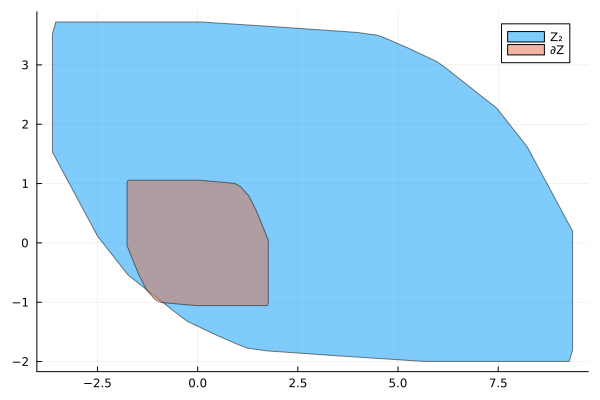

In [118]:
plot_diff_zono(∂Zout)

In [119]:
status = search(N₁, N₂, ∂Zin, ∂Zout, prop_state, branch_splits)

UNKNOWN::VerificationStatus = 0

In [120]:
if status == VeryDiff.UNKNOWN
    branch_and_bound(splits, branch_splits, split_candidates)
    neuron_splits += 1
end

1

In [121]:
branch_splits = popfirst!(splits)
∂Zout, split_candidates = propagate(∂Zin, prop_state, branch_splits)
branch_splits

1-element Vector{SplitNode}:
 SplitNode(2, 12, 1, -1)

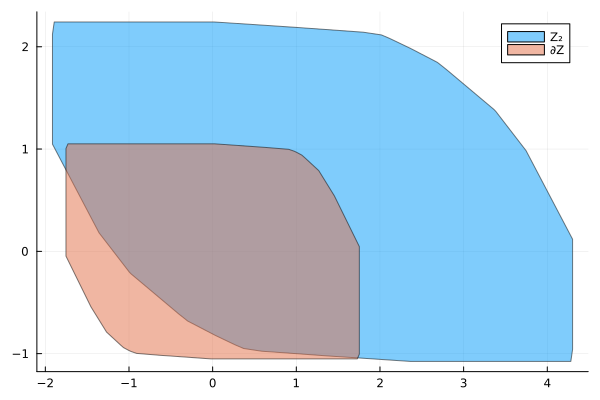

In [122]:
plot_diff_zono(∂Zout)

In [123]:
status = search(N₁, N₂, ∂Zin, ∂Zout, prop_state, branch_splits)

UNKNOWN::VerificationStatus = 0

In [124]:
if status == VeryDiff.UNKNOWN
    branch_and_bound(splits, branch_splits, split_candidates)
    neuron_splits += 1
end

2

In [125]:
branch_splits = popfirst!(splits)
∂Zout, split_candidates = propagate(∂Zin, prop_state, branch_splits)
branch_splits

1-element Vector{SplitNode}:
 SplitNode(2, 12, 1, 1)

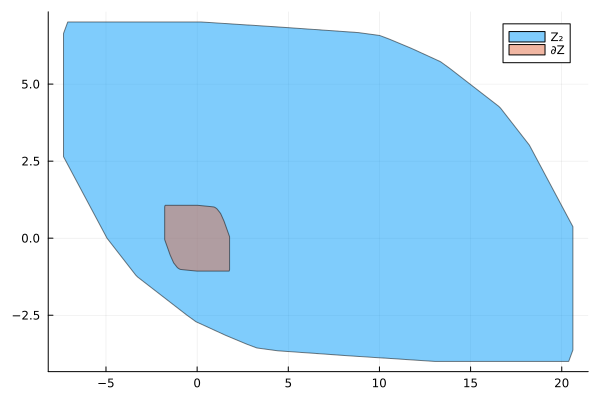

In [126]:
plot_diff_zono(∂Zout)

In [127]:
status = search(N₁, N₂, ∂Zin, ∂Zout, prop_state, branch_splits)

UNKNOWN::VerificationStatus = 0

In [128]:
if status == VeryDiff.UNKNOWN
    branch_and_bound(splits, branch_splits, split_candidates)
    neuron_splits += 1
end

3

In [129]:
branch_splits = popfirst!(splits)
∂Zout, split_candidates = propagate(∂Zin, prop_state, branch_splits)
branch_splits

2-element Vector{SplitNode}:
 SplitNode(2, 12, 1, -1)
 SplitNode(1, 12, 1, -1)

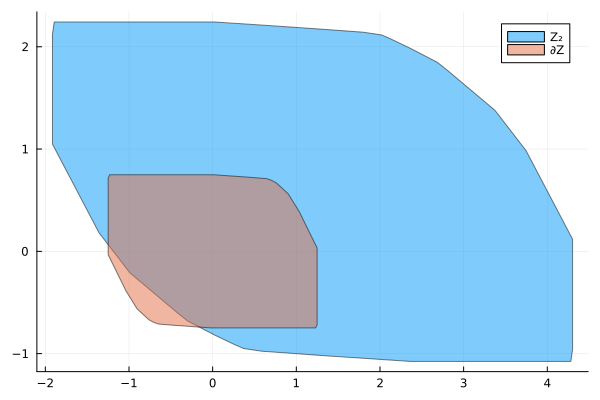

In [130]:
plot_diff_zono(∂Zout)

In [131]:
status = search(N₁, N₂, ∂Zin, ∂Zout, prop_state, branch_splits)

UNKNOWN::VerificationStatus = 0

In [132]:
if status == VeryDiff.UNKNOWN
    branch_and_bound(splits, branch_splits, split_candidates)
    neuron_splits += 1
end

4

In [133]:
branch_splits = popfirst!(splits)
∂Zout, split_candidates = propagate(∂Zin, prop_state, branch_splits)
branch_splits

2-element Vector{SplitNode}:
 SplitNode(2, 12, 1, -1)
 SplitNode(1, 12, 1, 1)

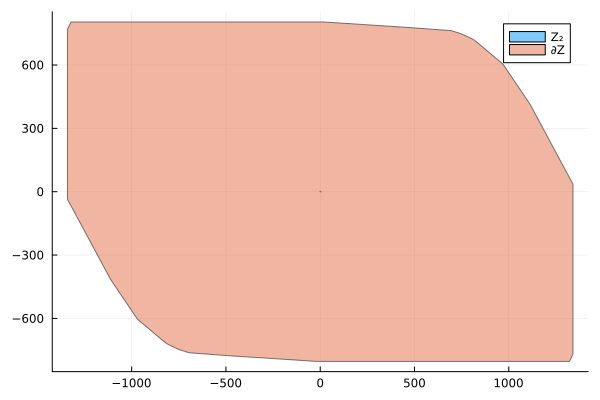

In [134]:
plot_diff_zono(∂Zout)

In [135]:
status = search(N₁, N₂, ∂Zin, ∂Zout, prop_state, branch_splits)

UNKNOWN::VerificationStatus = 0

In [136]:
if status == VeryDiff.UNKNOWN
    branch_and_bound(splits, branch_splits, split_candidates)
    neuron_splits += 1
end

5

In [137]:
branch_splits = popfirst!(splits)
∂Zout, split_candidates = propagate(∂Zin, prop_state, branch_splits)
branch_splits

2-element Vector{SplitNode}:
 SplitNode(2, 12, 1, 1)
 SplitNode(2, 22, 1, -1)

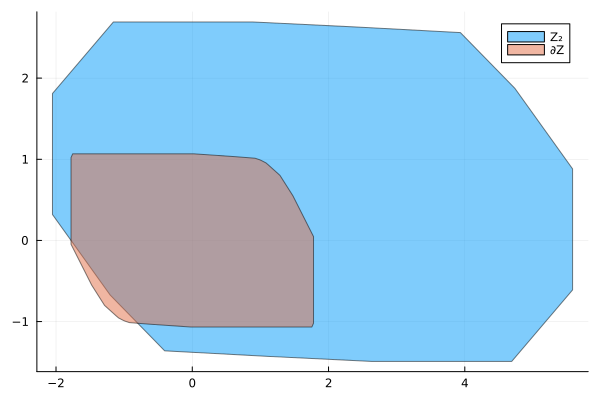

In [138]:
plot_diff_zono(∂Zout)

In [139]:
status = search(N₁, N₂, ∂Zin, ∂Zout, prop_state, branch_splits)

UNKNOWN::VerificationStatus = 0

In [140]:
if status == VeryDiff.UNKNOWN
    branch_and_bound(splits, branch_splits, split_candidates)
    neuron_splits += 1
end

6

In [141]:
branch_splits = popfirst!(splits)
∂Zout, split_candidates = propagate(∂Zin, prop_state, branch_splits)
branch_splits

2-element Vector{SplitNode}:
 SplitNode(2, 12, 1, 1)
 SplitNode(2, 22, 1, 1)

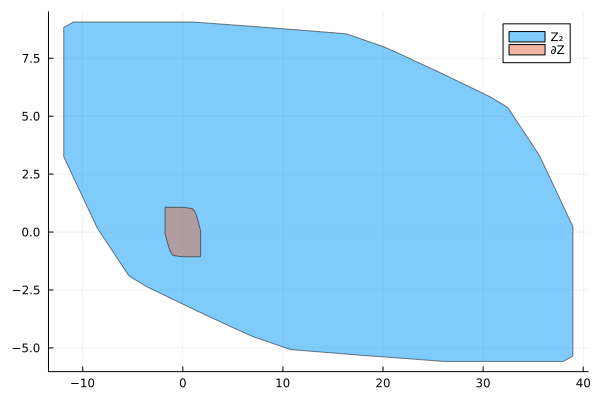

In [142]:
plot_diff_zono(∂Zout)

In [143]:
status = search(N₁, N₂, ∂Zin, ∂Zout, prop_state, branch_splits)

UNKNOWN::VerificationStatus = 0

In [144]:
if status == VeryDiff.UNKNOWN
    branch_and_bound(splits, branch_splits, split_candidates)
    neuron_splits += 1
end

7

In [145]:
branch_splits = popfirst!(splits)
∂Zout, split_candidates = propagate(∂Zin, prop_state, branch_splits)
branch_splits

3-element Vector{SplitNode}:
 SplitNode(2, 12, 1, -1)
 SplitNode(1, 12, 1, -1)
 SplitNode(1, 9, 1, -1)

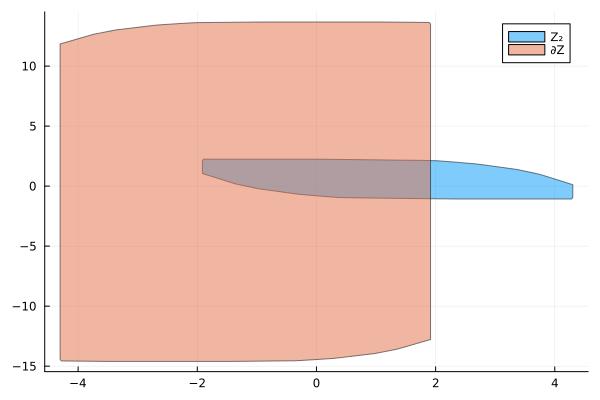

In [146]:
plot_diff_zono(∂Zout)

In [147]:
status = search(N₁, N₂, ∂Zin, ∂Zout, prop_state, branch_splits)

UNKNOWN::VerificationStatus = 0

In [148]:
if status == VeryDiff.UNKNOWN
    branch_and_bound(splits, branch_splits, split_candidates)
    neuron_splits += 1
end

8

In [149]:
branch_splits = popfirst!(splits)
∂Zout, split_candidates = propagate(∂Zin, prop_state, branch_splits)
branch_splits

3-element Vector{SplitNode}:
 SplitNode(2, 12, 1, -1)
 SplitNode(1, 12, 1, -1)
 SplitNode(1, 9, 1, 1)

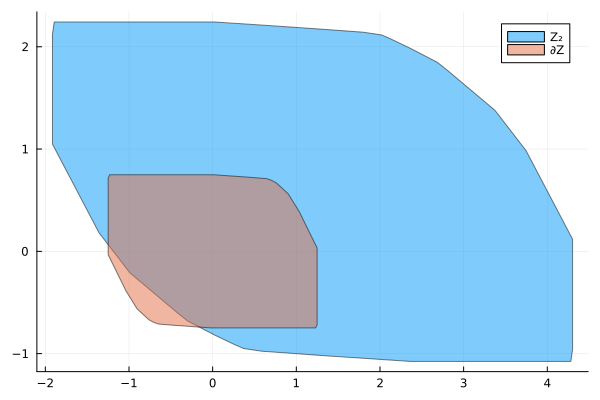

In [150]:
plot_diff_zono(∂Zout)

In [151]:
status = search(N₁, N₂, ∂Zin, ∂Zout, prop_state, branch_splits)

UNKNOWN::VerificationStatus = 0

In [152]:
if status == VeryDiff.UNKNOWN
    branch_and_bound(splits, branch_splits, split_candidates)
    neuron_splits += 1
end

9

In [153]:
branch_splits = popfirst!(splits)
∂Zout, split_candidates = propagate(∂Zin, prop_state, branch_splits)
branch_splits

3-element Vector{SplitNode}:
 SplitNode(2, 12, 1, -1)
 SplitNode(1, 12, 1, 1)
 SplitNode(1, 22, 1, -1)

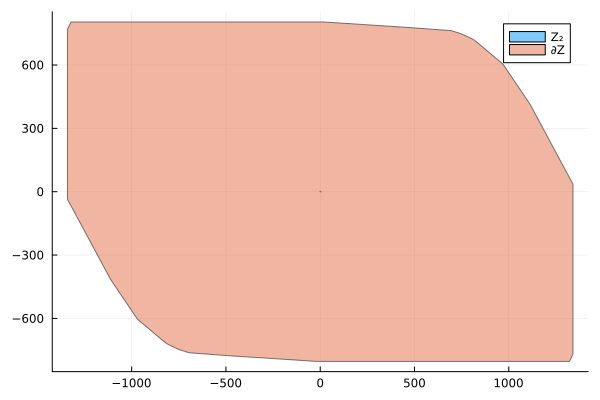

In [154]:
plot_diff_zono(∂Zout)

In [155]:
status = search(N₁, N₂, ∂Zin, ∂Zout, prop_state, branch_splits)

UNKNOWN::VerificationStatus = 0

In [156]:
if status == VeryDiff.UNKNOWN
    branch_and_bound(splits, branch_splits, split_candidates)
    neuron_splits += 1
end

10

In [157]:
branch_splits = popfirst!(splits)
∂Zout, split_candidates = propagate(∂Zin, prop_state, branch_splits)
branch_splits

3-element Vector{SplitNode}:
 SplitNode(2, 12, 1, -1)
 SplitNode(1, 12, 1, 1)
 SplitNode(1, 22, 1, 1)

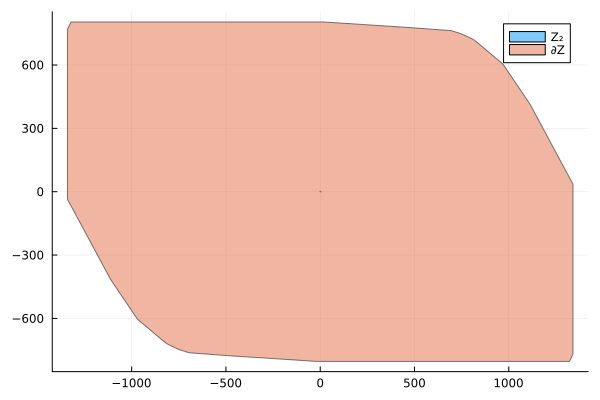

In [158]:
plot_diff_zono(∂Zout)

In [159]:
status = search(N₁, N₂, ∂Zin, ∂Zout, prop_state, branch_splits)

UNKNOWN::VerificationStatus = 0

In [160]:
if status == VeryDiff.UNKNOWN
    branch_and_bound(splits, branch_splits, split_candidates)
    neuron_splits += 1
end

11

In [161]:
branch_splits = popfirst!(splits)
∂Zout, split_candidates = propagate(∂Zin, prop_state, branch_splits)
branch_splits

3-element Vector{SplitNode}:
 SplitNode(2, 12, 1, 1)
 SplitNode(2, 22, 1, -1)
 SplitNode(1, 12, 1, -1)

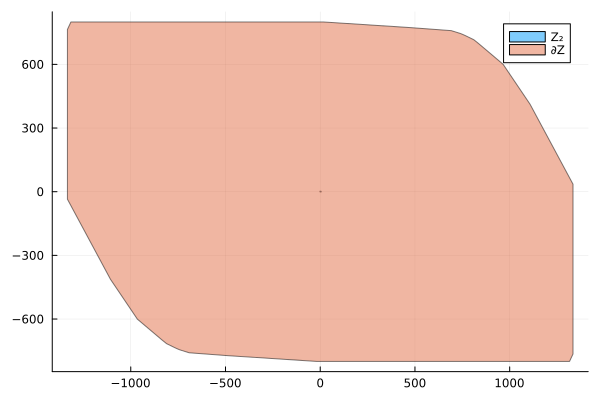

In [162]:
plot_diff_zono(∂Zout)

In [163]:
status = search(N₁, N₂, ∂Zin, ∂Zout, prop_state, branch_splits)

UNKNOWN::VerificationStatus = 0

In [164]:
if status == VeryDiff.UNKNOWN
    branch_and_bound(splits, branch_splits, split_candidates)
    neuron_splits += 1
end

12

In [165]:
branch_splits = popfirst!(splits)
∂Zout, split_candidates = propagate(∂Zin, prop_state, branch_splits)
branch_splits

3-element Vector{SplitNode}:
 SplitNode(2, 12, 1, 1)
 SplitNode(2, 22, 1, -1)
 SplitNode(1, 12, 1, 1)

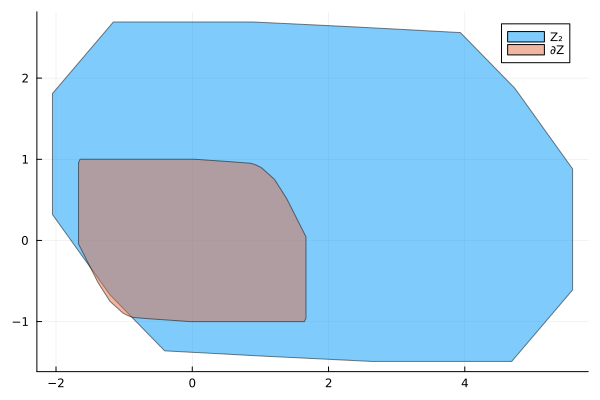

In [166]:
plot_diff_zono(∂Zout)

In [167]:
status = search(N₁, N₂, ∂Zin, ∂Zout, prop_state, branch_splits)

UNKNOWN::VerificationStatus = 0

In [168]:
if status == VeryDiff.UNKNOWN
    branch_and_bound(splits, branch_splits, split_candidates)
    neuron_splits += 1
end

13

In [169]:
branch_splits = popfirst!(splits)
∂Zout, split_candidates = propagate(∂Zin, prop_state, branch_splits)
branch_splits

3-element Vector{SplitNode}:
 SplitNode(2, 12, 1, 1)
 SplitNode(2, 22, 1, 1)
 SplitNode(1, 12, 1, -1)

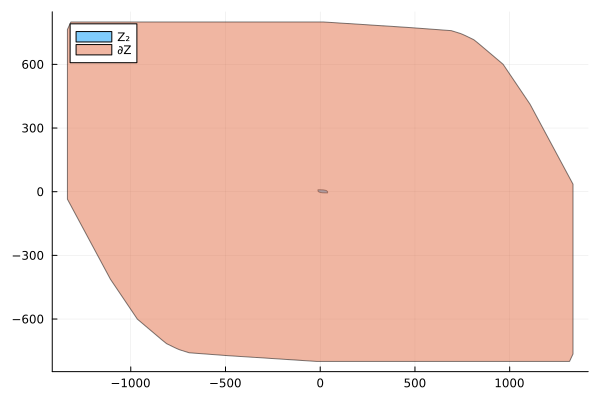

In [170]:
plot_diff_zono(∂Zout)

In [171]:
status = search(N₁, N₂, ∂Zin, ∂Zout, prop_state, branch_splits)

UNKNOWN::VerificationStatus = 0

In [172]:
if status == VeryDiff.UNKNOWN
    branch_and_bound(splits, branch_splits, split_candidates)
    neuron_splits += 1
end

14

In [173]:
branch_splits = popfirst!(splits)
∂Zout, split_candidates = propagate(∂Zin, prop_state, branch_splits)
branch_splits

3-element Vector{SplitNode}:
 SplitNode(2, 12, 1, 1)
 SplitNode(2, 22, 1, 1)
 SplitNode(1, 12, 1, 1)

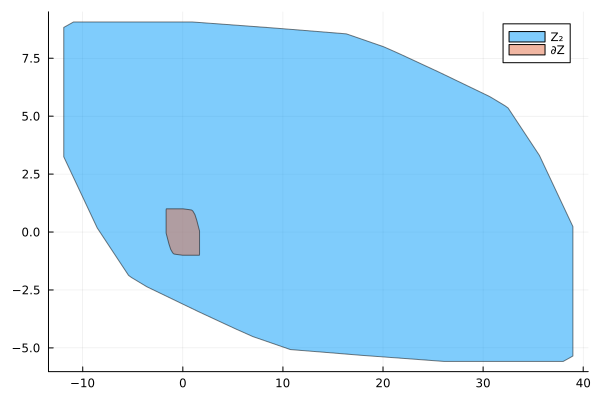

In [174]:
plot_diff_zono(∂Zout)

In [175]:
status = search(N₁, N₂, ∂Zin, ∂Zout, prop_state, branch_splits)

UNKNOWN::VerificationStatus = 0

In [176]:
if status == VeryDiff.UNKNOWN
    branch_and_bound(splits, branch_splits, split_candidates)
    neuron_splits += 1
end

15

In [177]:
branch_splits = popfirst!(splits)
∂Zout, split_candidates = propagate(∂Zin, prop_state, branch_splits)
branch_splits

4-element Vector{SplitNode}:
 SplitNode(2, 12, 1, -1)
 SplitNode(1, 12, 1, -1)
 SplitNode(1, 9, 1, -1)
 SplitNode(2, 9, 1, -1)

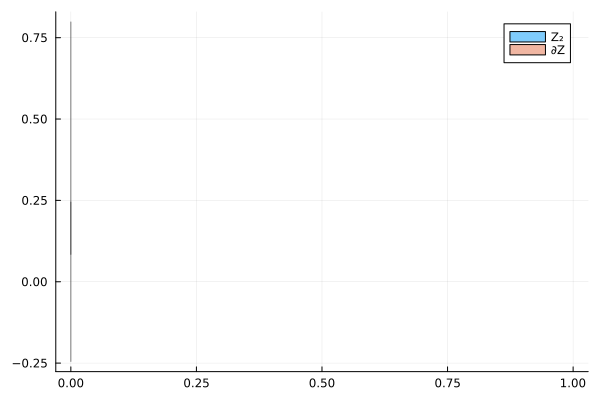

In [178]:
plot_diff_zono(∂Zout)

In [179]:
status = search(N₁, N₂, ∂Zin, ∂Zout, prop_state, branch_splits)

SAFE::VerificationStatus = 1

In [180]:
if status == VeryDiff.UNKNOWN
    branch_and_bound(splits, branch_splits, split_candidates)
    neuron_splits += 1
end

In [181]:
branch_splits = popfirst!(splits)
∂Zout, split_candidates = propagate(∂Zin, prop_state, branch_splits)
branch_splits

4-element Vector{SplitNode}:
 SplitNode(2, 12, 1, -1)
 SplitNode(1, 12, 1, -1)
 SplitNode(1, 9, 1, -1)
 SplitNode(2, 9, 1, 1)

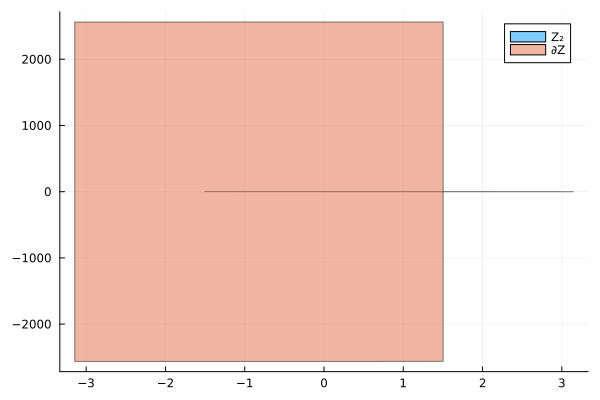

In [182]:
plot_diff_zono(∂Zout)

In [183]:
status = search(N₁, N₂, ∂Zin, ∂Zout, prop_state, branch_splits)

UNKNOWN::VerificationStatus = 0

In [184]:
if status == VeryDiff.UNKNOWN
    branch_and_bound(splits, branch_splits, split_candidates)
    neuron_splits += 1
end

16

In [185]:
branch_splits = popfirst!(splits)
∂Zout, split_candidates = propagate(∂Zin, prop_state, branch_splits)
branch_splits

4-element Vector{SplitNode}:
 SplitNode(2, 12, 1, -1)
 SplitNode(1, 12, 1, -1)
 SplitNode(1, 9, 1, 1)
 SplitNode(2, 9, 1, -1)

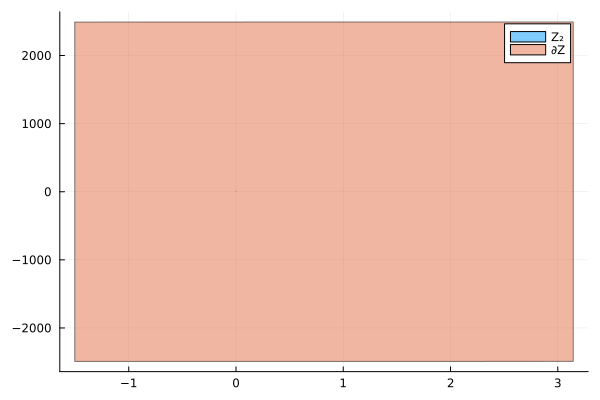

In [186]:
plot_diff_zono(∂Zout)

In [187]:
status = search(N₁, N₂, ∂Zin, ∂Zout, prop_state, branch_splits)

UNKNOWN::VerificationStatus = 0

In [188]:
if status == VeryDiff.UNKNOWN
    branch_and_bound(splits, branch_splits, split_candidates)
    neuron_splits += 1
end

17

In [189]:
branch_splits = popfirst!(splits)
∂Zout, split_candidates = propagate(∂Zin, prop_state, branch_splits)
branch_splits

4-element Vector{SplitNode}:
 SplitNode(2, 12, 1, -1)
 SplitNode(1, 12, 1, -1)
 SplitNode(1, 9, 1, 1)
 SplitNode(2, 9, 1, 1)

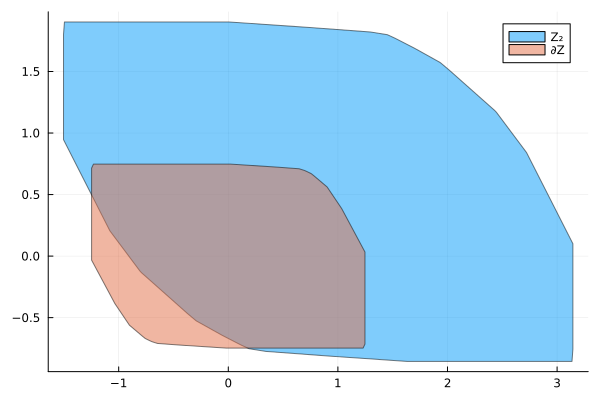

In [190]:
plot_diff_zono(∂Zout)

In [191]:
status = search(N₁, N₂, ∂Zin, ∂Zout, prop_state, branch_splits)

UNKNOWN::VerificationStatus = 0

In [192]:
if status == VeryDiff.UNKNOWN
    branch_and_bound(splits, branch_splits, split_candidates)
    neuron_splits += 1
end

18

In [193]:
branch_splits = popfirst!(splits)
∂Zout, split_candidates = propagate(∂Zin, prop_state, branch_splits)
branch_splits

4-element Vector{SplitNode}:
 SplitNode(2, 12, 1, -1)
 SplitNode(1, 12, 1, 1)
 SplitNode(1, 22, 1, -1)
 SplitNode(1, 9, 1, -1)

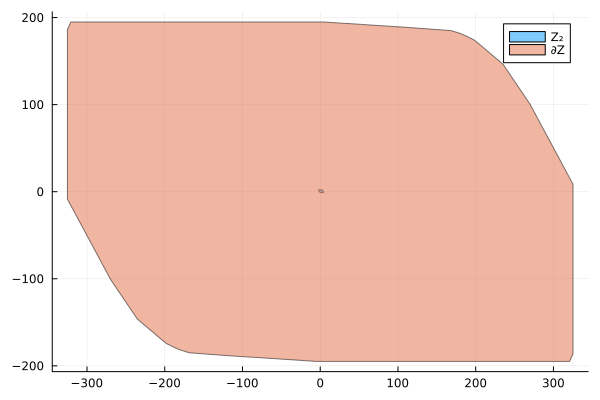

In [194]:
plot_diff_zono(∂Zout)

In [195]:
status = search(N₁, N₂, ∂Zin, ∂Zout, prop_state, branch_splits)

UNKNOWN::VerificationStatus = 0

In [196]:
if status == VeryDiff.UNKNOWN
    branch_and_bound(splits, branch_splits, split_candidates)
    neuron_splits += 1
end

19

In [197]:
branch_splits = popfirst!(splits)
∂Zout, split_candidates = propagate(∂Zin, prop_state, branch_splits)
branch_splits

4-element Vector{SplitNode}:
 SplitNode(2, 12, 1, -1)
 SplitNode(1, 12, 1, 1)
 SplitNode(1, 22, 1, -1)
 SplitNode(1, 9, 1, 1)

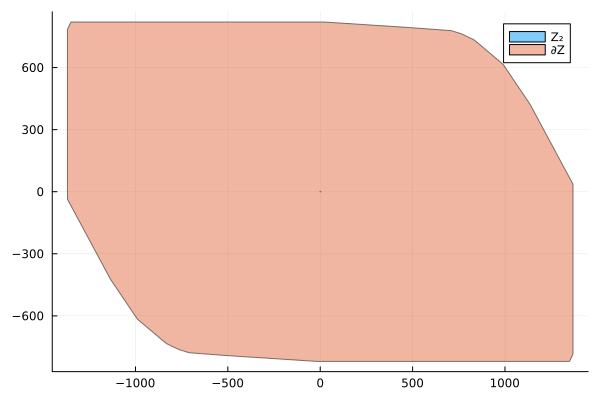

In [198]:
plot_diff_zono(∂Zout)

In [199]:
status = search(N₁, N₂, ∂Zin, ∂Zout, prop_state, branch_splits)

UNKNOWN::VerificationStatus = 0

In [200]:
if status == VeryDiff.UNKNOWN
    branch_and_bound(splits, branch_splits, split_candidates)
    neuron_splits += 1
end

20

In [201]:
branch_splits = popfirst!(splits)
∂Zout, split_candidates = propagate(∂Zin, prop_state, branch_splits)
branch_splits

4-element Vector{SplitNode}:
 SplitNode(2, 12, 1, -1)
 SplitNode(1, 12, 1, 1)
 SplitNode(1, 22, 1, 1)
 SplitNode(1, 9, 1, -1)

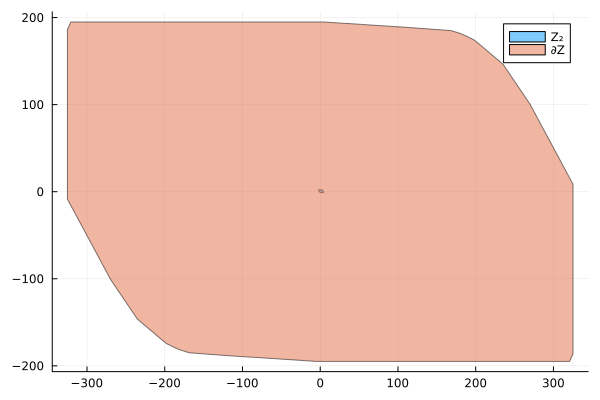

In [202]:
plot_diff_zono(∂Zout)

In [203]:
status = search(N₁, N₂, ∂Zin, ∂Zout, prop_state, branch_splits)

UNKNOWN::VerificationStatus = 0

In [204]:
if status == VeryDiff.UNKNOWN
    branch_and_bound(splits, branch_splits, split_candidates)
    neuron_splits += 1
end

21

In [205]:
branch_splits = popfirst!(splits)
∂Zout, split_candidates = propagate(∂Zin, prop_state, branch_splits)
branch_splits

4-element Vector{SplitNode}:
 SplitNode(2, 12, 1, -1)
 SplitNode(1, 12, 1, 1)
 SplitNode(1, 22, 1, 1)
 SplitNode(1, 9, 1, 1)

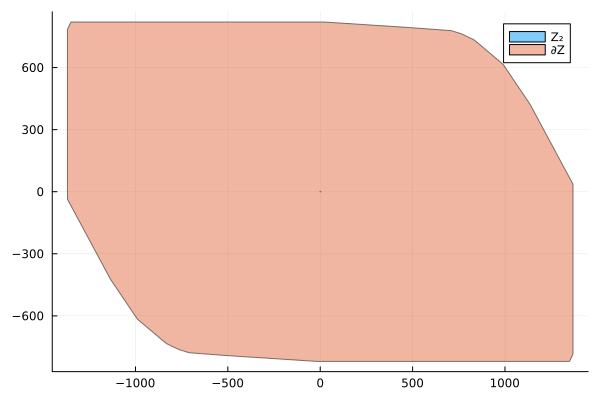

In [206]:
plot_diff_zono(∂Zout)